<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Information-Bottleneck-for-Decision-Trees" data-toc-modified-id="Information-Bottleneck-for-Decision-Trees-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Information Bottleneck for Decision Trees</a></span><ul class="toc-item"><li><span><a href="#Proposal" data-toc-modified-id="Proposal-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Proposal</a></span></li><li><span><a href="#Implementation-of-the-algorithm" data-toc-modified-id="Implementation-of-the-algorithm-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Implementation of the algorithm</a></span></li><li><span><a href="#IB-Tree-estimator-properties:-consitency-and-bias" data-toc-modified-id="IB-Tree-estimator-properties:-consitency-and-bias-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>IB Tree estimator properties: consitency and bias</a></span></li><li><span><a href="#Generalization:-IB-and-VC-dimension" data-toc-modified-id="Generalization:-IB-and-VC-dimension-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Generalization: IB and VC dimension</a></span></li></ul></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualizations</a></span><ul class="toc-item"><li><span><a href="#Capacity-of--a-tree" data-toc-modified-id="Capacity-of--a-tree-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Capacity of  a tree</a></span></li></ul></li><li><span><a href="#Real-world-experiment" data-toc-modified-id="Real-world-experiment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Real world experiment</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Loss:-Categorical-Information-Bottleneck" data-toc-modified-id="Loss:-Categorical-Information-Bottleneck-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Loss: Categorical Information Bottleneck</a></span></li></ul></li><li><span><a href="#Tree" data-toc-modified-id="Tree-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Tree</a></span><ul class="toc-item"><li><span><a href="#Circle-regularized-with-IB,-$\beta=0.1$" data-toc-modified-id="Circle-regularized-with-IB,-$\beta=0.1$-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Circle regularized with IB, $\beta=0.1$</a></span></li><li><span><a href="#Circle,-regularized-with-max_depth=20" data-toc-modified-id="Circle,-regularized-with-max_depth=20-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Circle, regularized with <code>max_depth=20</code></a></span></li><li><span><a href="#Circle,-regularized-with-min_n" data-toc-modified-id="Circle,-regularized-with-min_n-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Circle, regularized with <code>min_n</code></a></span></li><li><span><a href="#Easy-data" data-toc-modified-id="Easy-data-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Easy data</a></span></li><li><span><a href="#Evaluate-Probability-to-end-up-in-a-leave-with-leave-size-N" data-toc-modified-id="Evaluate-Probability-to-end-up-in-a-leave-with-leave-size-N-3.1.5"><span class="toc-item-num">3.1.5&nbsp;&nbsp;</span>Evaluate Probability to end up in a leave with leave size N</a></span></li></ul></li><li><span><a href="#Impact-of-noise,-add-random-projections" data-toc-modified-id="Impact-of-noise,-add-random-projections-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Impact of noise, add random projections</a></span></li><li><span><a href="#Utils" data-toc-modified-id="Utils-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Utils</a></span></li></ul></li><li><span><a href="#Presentation" data-toc-modified-id="Presentation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Presentation</a></span></li></ul></div>

In [3]:
%load_ext autoreload
%autoreload 2
from ibtree import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Information Bottleneck for Decision Trees

## Proposal
Decision trees are a class of machine learning algorithms that can be used for classification and regression problems. From an information theoretical perspective, they can be viewed as algorithms to construct optimal binary encodings $e: \mathcal{X} \mapsto \mathcal{B} $ for $\mathcal{B}$ being the set of binary words, and $\mathcal{X}$ being data sampled of an unkown distribution $P_X : \mathcal{X} \mapsto [0, 1]$.
It is interesting to analyze this in the information bottleneck framework (IB), which gives a justification to expect generalization.

Specifically, the following questions shall be answered:
- can we use decision trees to efficiently optimize for the IB objective? What is the time and space complexity of such an implementation?
- for which distributions $P_{X,Y}$ or probability densities $p_{X,Y}$ does this lead to a consistent unbiased estimator and for which distributions does it lead to a suboptimal estimator?
- What is the VC dimension of this algorithm? Can we find generalization bounds?
- How does this algorithm perform on different toy and real world datasets in comparison to other decision trees? How does a gradient boosted ensemble of these decision trees perform on a real world dataset, compared to a regular xgboost model?
- In the original IB paper, the authors propose the The information bottleneck iterative algorithm. How does it compare to IB trees?

## Implementation of the algorithm

The IB objective is given as
$$ J'(e) = \beta I(X, e(X)) - I(e(X), y)  = \beta ( H(X) - H(X|e(X) ) - H(y) + H(y|e(X)) $$
If we ignore all terms independent of $e$, we get:
$$ J(e) =  H(y|e(X)) - \beta H(X|e(X)) $$

It is straight forward to apply the IB method to decision trees. The first term  $H(y|e(X))$ is a widely used objective in decision trees, and the second term $\beta H(X|e(X))$ serves as a regularizer. 

In the fitting phase, the IB tree tries to find a binary split $f(x) = x_i > t$ such that $J(f)$ is minimal. If the optimal split is a constant function over the samples, all points are grouped into the same split and the (sub)tree is a leaf. In this way, pruning is no longer necessary.

The loss function for a non-leaf tree can be expressed as:


$$  J = H(y|e(X)) - \beta H(X|e(X)) $$
$$ = \sum_{i=0}^1 ( P(e(X)=i) * (H(y|e(X)=i) - \beta H(X|e(X)=i)) ) $$
$$ = P(e(X)=0) * J(left) + P(e(X)=1) * J(right) $$

The loss of a leaf is simply:

$$    J = H(y|e(X)) - \beta H(X|e(X)) $$
$$      = H(y) - \beta H(X) $$

To estimate $H(X)$, we simply assume a uniform distribution over all samples, i.e. $log(N)$.

This allows an efficient recursive computation of the loss.



## IB Tree estimator properties: consitency and bias
Notes:
- This is definitely not in general a consistent estimator: examples where the algorithm fails to converge to a good solution is given in the experimental section (caro data).
- This estimator also has a bias, since it can only express decision boundaries of the type ${x : \bigwedge\limits_{i=1}^{depth} x_i = t_i$} $ (see experiments) - it cannot accurately represent a circle and favors squared shapes in the absence of sufficient samples
- An interesting subclass of distributions are those that can be expressed perfectly by a decision tree of limited size
    - even there, the greedy optimization may get stuck in local optima (caro data problem)
    - but good news is that for most distrubitions that can be expressed, the caro data problem does not occur

## Generalization: IB and VC dimension
An upper bound for the VC dimension of a decision tree is $2^{#leaves}$.
- Given $N, \beta$, what is the VC dimension of an IB tree? Can we find an upper bound for $I(X, e(X)) \leq \psi(D)$?
- What is the implied generalization bound?

# Visualizations

1. Dataset vs optimal split Information Gain, vs IB
2. Tree learned animation with different heights

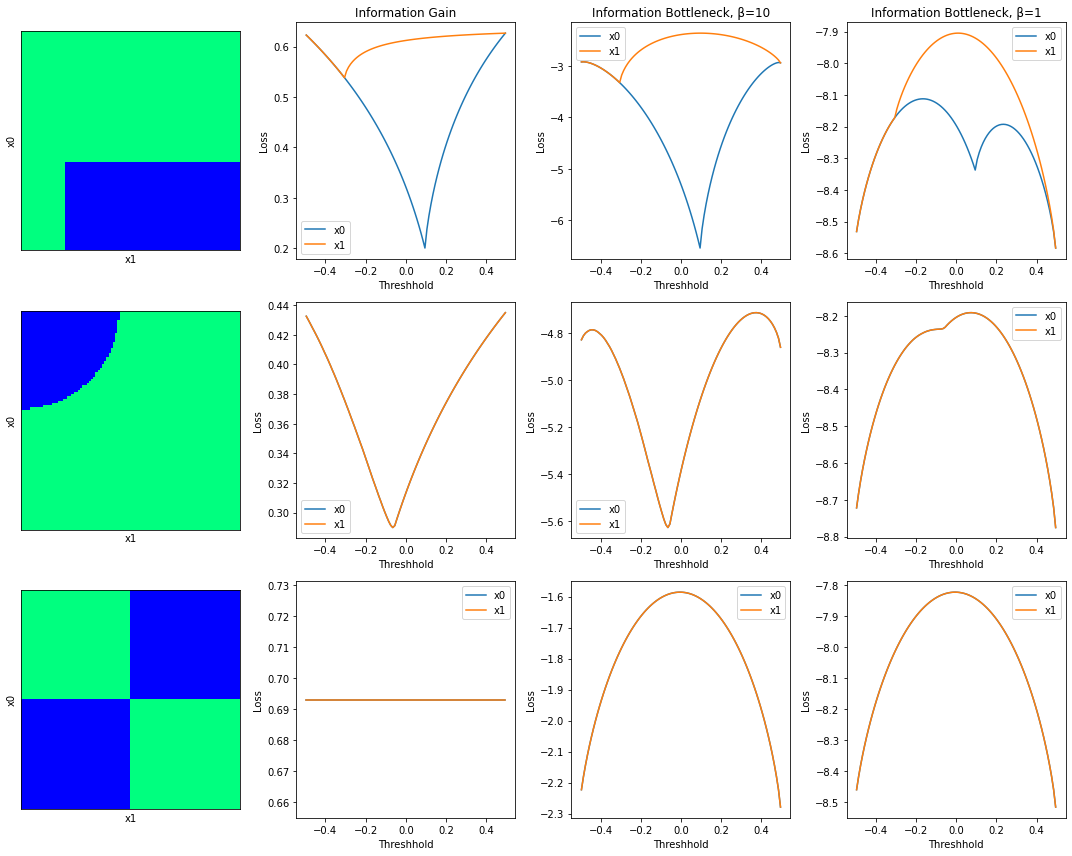

In [4]:
from ibtree.datasets import easy_data, caro_data, circle_data
from ibtree.visualize import *

plt.figure(figsize=(15,12))

plt.subplot(341)
X, y = easy_data()
plot_on_grid(y[:,0], 100)

plt.subplot(342)
plt.title("Information Gain")
optimal_split_plot(X, y, entropy)

plt.subplot(343)
plt.title("Information Bottleneck, β=10")
optimal_split_plot(X, y, categorical_IB(10))

plt.subplot(344)
plt.title("Information Bottleneck, β=1")
optimal_split_plot(X, y, categorical_IB(1))


plt.subplot(345)
X, y = circle_data()
plot_on_grid(y[:,0], 100)

plt.subplot(346)
optimal_split_plot(X, y, entropy)

plt.subplot(347)
optimal_split_plot(X, y, categorical_IB(10))

plt.subplot(348)
optimal_split_plot(X, y, categorical_IB(1))

plt.subplot(349)
X, y = caro_data()
plot_on_grid(y[:,0], 100)

plt.subplot(3,4,10)
optimal_split_plot(X, y, entropy)

plt.subplot(3,4,11)
optimal_split_plot(X, y, categorical_IB(10))

plt.subplot(3,4,12)
optimal_split_plot(X, y, categorical_IB(1))

plt.tight_layout()
plt.show()

## Capacity of  a tree

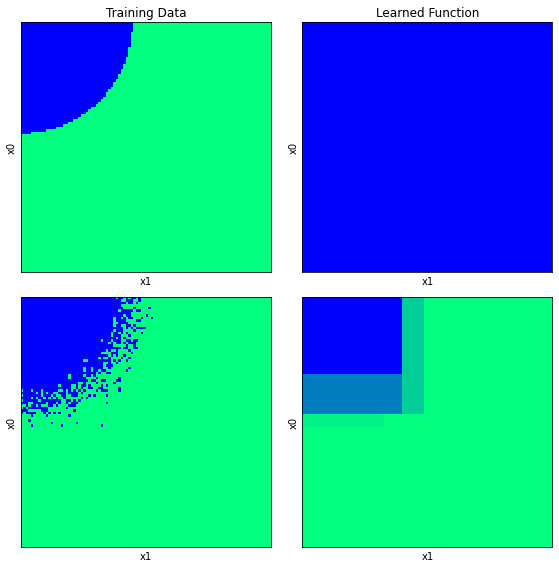

Tree with 58 leaves and depth of 10


In [17]:
from ibtree.datasets import circle_y


tree = DecisionTree(entropy, min_n=20)
X, y = circle_data()
tree.fit(X, y)
y_pred = tree.predict(X)

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.title("Training Data")
plot_on_grid(y[:, 0], 100)
plt.subplot(222)
plt.title("Learned Function")
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)


y_train = circle_y(X + np.random.normal(0, 0.05, size=X.shape))
tree = DecisionTree(entropy, min_n=20)
tree.fit(X, y_train)

plt.subplot(223)
plot_on_grid(y_train[:,0], 100)

plt.subplot(224)
y_pred = tree.predict(X, max_depth=3)       
plot_on_grid(y_pred[:, 0], 100)
plt.tight_layout()
plt.show()

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")


0
1
2
3
4
5
6
7
8
9


<Figure size 432x288 with 0 Axes>

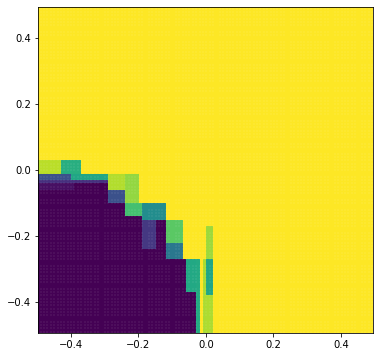

In [42]:
import matplotlib.animation as animation
from IPython.display import HTML


class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, x, tree):
        self.x = x
        self.generate_data(x, tree)

        # Setup the figure and axes...
        plt.clf()
        self.fig, self.ax = plt.subplots(figsize=(6,6))
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=int(10000/tree.depth),
                                           frames=range(tree.depth), init_func=self.setup_plot, blit=True)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        x, y = self.x, self.Y[0]
        xmin, xmax = self.x[:,0].min(), self.x[:,0].max()
        ymin, ymax = self.x[:,1].min(), self.x[:,1].max()
        
        self.scat = self.ax.scatter(x[:,0], x[:,1], s=0, animated=True, marker="s")
        self.ax.axis([xmin, xmax, ymin, ymax]) 

        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
    
    def generate_data(self, x, tree):
        # change: method that changes the model or the plane or whatever
        frames_y = []
        for i in range(tree.depth):
            y = tree.predict(x, max_depth=i+1)[:,0]
            frames_y.append(y)
        self.Y = np.array(frames_y)
            
    def update(self, i):
        print(i)
        # Set x and y data
        self.scat.set_offsets(self.x)
        # Set colors..
        y = self.Y[i]
        self.scat.set_array(y)
        self.scat.set_sizes(0*y+6)

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

    def show(self):
        return HTML(self.ani.to_jshtml())

    
AnimatedScatter(X, tree).show()

# Real world experiment

### Loss: Categorical Information Bottleneck

In [ ]:
X, y = easy_data()
optimal_split_plot(X, y, categorical_IB(0.1))
optimal_split_plot(X, y, categorical_IB(0.2))
optimal_split_plot(X, y, categorical_IB(0.5))

## Tree

### Circle regularized with IB, $\beta=0.1$

In [ ]:
tree = DecisionTree(categorical_IB(0.15), plot_optimal_split=False)
X, y = circle_data()
tree.fit(X, y)
tree.print_tree()
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")
structure = tree.color(X)

### Circle, regularized with `max_depth=20`

In [ ]:
tree = DecisionTree(entropy, max_depth=8)
X, y = circle_data()
tree.fit(X, y)
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")

### Circle, regularized with `min_n`

### Easy data

In [ ]:
# y[X[:,0]<0.1,0] = 1
# y[X[:,1]<-0.3,0] = 1

tree = DecisionTree(categorical_IB(beta=0.625),
                    max_depth=2, plot_optimal_split=True)
X, y = easy_data()
tree.fit(X, y)
y_pred = tree.predict(X)
print("Learned function:")
plot_on_grid(y_pred[:, 0], 100)

print("Structure of the tree")
structure = tree.color(X)
plot_on_grid(structure, 100)
print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")

tree.plot_2d_tree()

### Evaluate Probability to end up in a leave with leave size N

In [ ]:
def fill_missing_x_with(x, y, fill=0):
    c = dict(zip(x.tolist(), y.tolist()))
    x = np.arange(x.min(), x.max()+0.5, 1)
    y = np.array([c.get(s, 0)*s for s in x])
    return x, y


leaves = tree.get_leaves()
leaf_size = [i._N for i in leaves]
sizes, counts = np.unique(leaf_size, return_counts=True)
x, p_in_leav_of_size = fill_missing_x_with(sizes, sizes*counts, fill=0)
plt.plot(x, smooth(p_in_leav_of_size, mode='same', window=200))
plt.xlabel("Size of the leaf")
plt.ylabel("P(size(leaf))")
plt.title("P(sample is in leaf of size x)")
plt.show()

## Impact of noise, add random projections

In [ ]:
def uniform_label_noise(y, p_noise=0.1):
    y[:, 0] += np.round(np.random.uniform(low=0,
                                          high=0.5+p_noise/2, size=len(y)))
    y = y % 2
    y[:, 1] = 1 - y[:, 0]
    return y

X, y = circle_data()
X_train = X + np.random.normal(0, 0.025, size=X.shape)
plot_on_grid(circle_y(X_train)[:,0], 100)

tree = DecisionTree(categorical_IB(beta=0.075))
tree.fit(X_train, y)

# tree.print_tree()
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)


print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")
# structure = tree.color(X)
# plot_on_grid(structure, 100)

## Utils

# Presentation